<a href="https://colab.research.google.com/github/Rohan-crypt/Waste-Classification/blob/main/Waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project-1 Classification of E-Waste from Non E-Waste using MobileNetV2

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d kaanerkez/waste-classfication-dataset

# Unzip dataset
!unzip -q waste-classfication-dataset.zip -d /content/waste_dataset

Dataset URL: https://www.kaggle.com/datasets/kaanerkez/waste-classfication-dataset
License(s): Community Data License Agreement - Permissive - Version 1.0
waste-classfication-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/waste_dataset/balanced_waste_images/Battery/aug_0_106.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

!ls /content/waste_dataset/balanced_waste_images


 Battery     Keyboard	 Mobile    paper     Player	  trash
 cardboard   metal	 Mouse	   PCB	     Printer	 'Washing Machine'
 glass	     Microwave	 organic   plastic   Television


In [ ]:
import splitfolders

input_folder = "/content/waste_dataset/balanced_waste_images"
output_folder = "/content/waste_dataset/split_data"

# Split 80% training, 20% testing
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))


Copying files: 6782 files [00:00, 7614.24 files/s]


In [ ]:
!pip install split-folders

In [ ]:
# Check new folders created
!ls /content/waste_dataset/split_data


train  val


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/waste_dataset/split_data/train'
test_dir = '/content/waste_dataset/split_data/val'  # created by splitfolders

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5423 images belonging to 17 classes.
Found 1359 images belonging to 17 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
train_dir = '/content/waste_dataset/split_data/train'
val_dir = '/content/waste_dataset/split_data/val'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5423 images belonging to 17 classes.
Found 1359 images belonging to 17 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,279,761 (8.70 MB)

 Trainable params: 21,777 (85.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 105s 510ms/step - accuracy: 0.1055 - loss: 3.0644 - val_accuracy: 0.4238 - val_loss: 2.0659
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.3307 - loss: 2.1706 - val_accuracy: 0.6269 - val_loss: 1.4773
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 389ms/step - accuracy: 0.5052 - loss: 1.6252 - val_accuracy: 0.7057 - val_loss: 1.1576
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.6090 - loss: 1.3388 - val_accuracy: 0.7469 - val_loss: 0.9717
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.6472 - loss: 1.1726 - val_accuracy: 0.7667 - val_loss: 0.8521
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.6871 - loss: 1.0429 - val_accuracy: 0.7792 - val_loss: 0.7699
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.7153 - loss: 0.9290 - val_accuracy: 0.7903 - val_loss: 0.7139
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step - accuracy: 0.7198 - loss: 

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8066 - loss: 0.6200
✅ Validation Accuracy: 81.60%


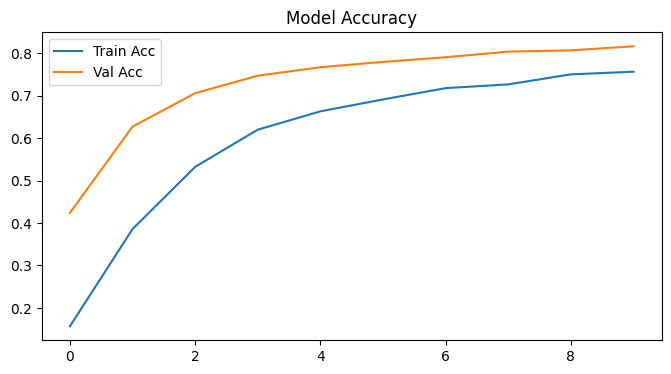

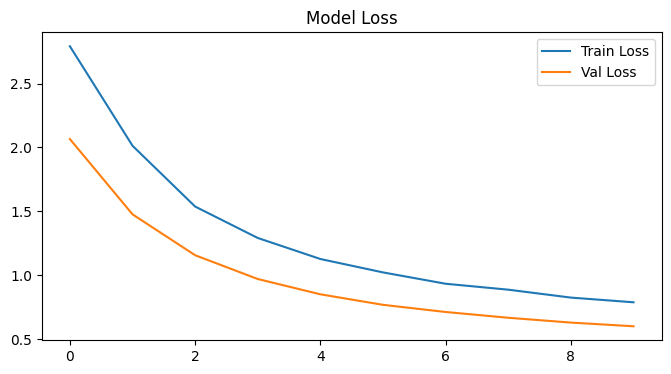

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
model.save("waste_classifier_mobilenetv2.h5")

from google.colab import files
files.download("waste_classifier_mobilenetv2.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>